In [48]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sys
import os
from comet_ml import Experiment

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
sns.set_theme()

from ift6758.models.utils import preprocess, predict_model,save_metrics_and_models_on_comet,compute_metrics
from ift6758.models.plotter import *
from dotenv import load_dotenv

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
import time

from comet_ml import API

from sklearn.linear_model import LogisticRegression


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
url = 'https://drive.google.com/file/d/1kM__riNHRPx5GsyuOH3yhiql3OZvwmuP/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
df = pd.read_csv(path)

In [50]:
df_train = df[df['season']!=20192020]

## question 3.1

In [51]:
# preprocess
X, Y ,df_train_preprocessed,_ =  preprocess(df_train,features = ['distance','angle'], standarize=True)

# train/test split
X_train, X_val, y_train, y_val = train_test_split(X,Y,random_state = 42, shuffle=True, stratify=Y)

# define and train model
model = LogisticRegression()

# fit_model
model.fit(X_train,y_train)
y_val_pred,y_val_prob = predict_model(model,X_val)

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/princesslove/itf-6758-team-4/1ddbdb3595454c098495e2351953b618
COMET INFO:   Others:
COMET INFO:     Name : question3.1
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git metadata                 : 1
COMET INFO:     git-patch (uncompressed)     : 1 (430.92 KB)
COMET INFO:     installed packages           : 1
COMET INFO:     notebook                     : 1
COMET INFO:     source_code                  : 1
COMET INFO: ---------------------------
COMET WARNING: Not all initial data has been logged for experiment 1ddbdb3595454c098495e2351953b618, call Experiment.end(

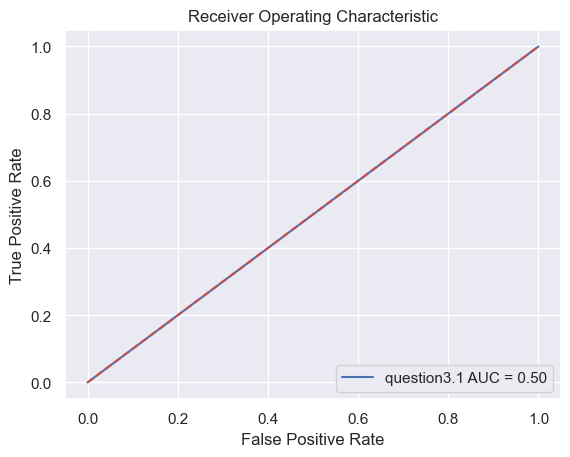

<Figure size 640x480 with 0 Axes>

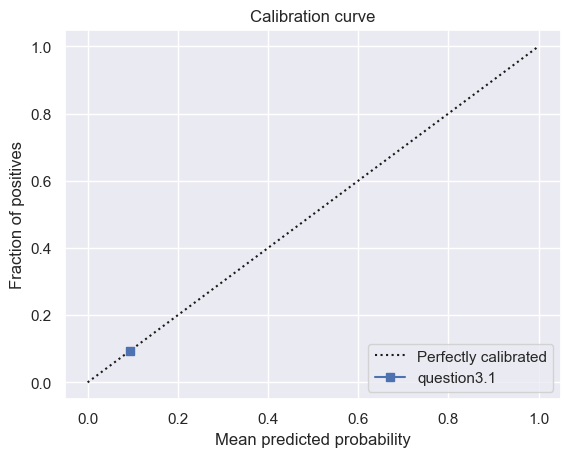

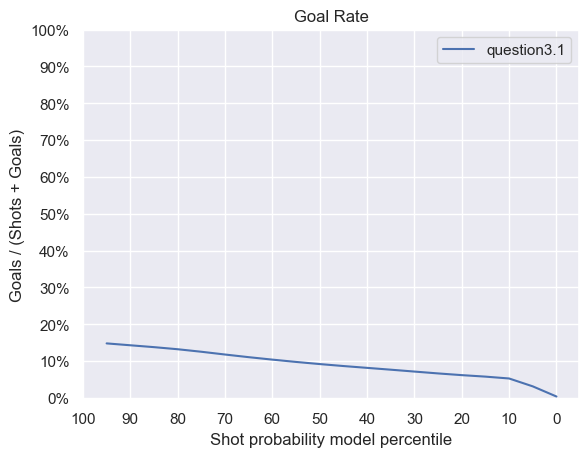

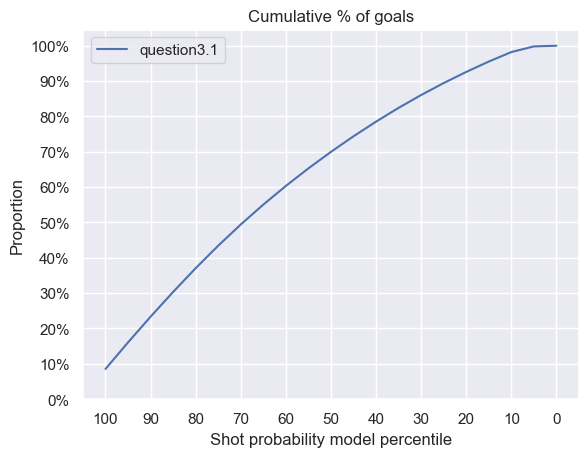

In [56]:
name_experiment = "question3.1"
model_dir = "LR"

save_metrics_and_models_on_comet(model,y_val,y_val_pred,y_val_prob,model_names=name_experiment,model_dir=model_dir,name_experiment=name_experiment,register_model = False, sklearn_model=True)

## question 5.1

In [201]:
# preprocess
X, Y ,df_train_preprocessed,_ =  preprocess(df_train,features = ['distance','angle'], standarize=True)

# train/test split
X_train, X_val, y_train, y_val = train_test_split(X,Y,random_state = 42, shuffle=True, stratify=Y)

# define and train model
model = XGBClassifier()

# fit_model
model.fit(X_train,y_train)
y_val_pred,y_val_prob = predict_model(model,X_val)

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/princesslove/itf-6758-team-4/1142c4bb38ee49f7a6e84db355a88587
COMET INFO:   Metrics:
COMET INFO:     AUC        : 0.5256150173078846
COMET INFO:     Accuracy   : 0.9109233659744429
COMET INFO:     Precision  : 0.9451651375304568
COMET INFO:     Recall     : 0.5256150173078846
COMET INFO:     f_score    : 0.5253582817481836
COMET INFO:     model_name : question5.2_with_grid_search
COMET INFO:   Others:
COMET INFO:     Name : question5.2_with_grid_search
COMET INFO:   Parameters:
COMET INFO:     C                                               : 0.001
COMET INFO:     begin_iteration                                 : 0
COMET INFO:     class_weight                                    : 1
COMET INFO:     classification                                  :

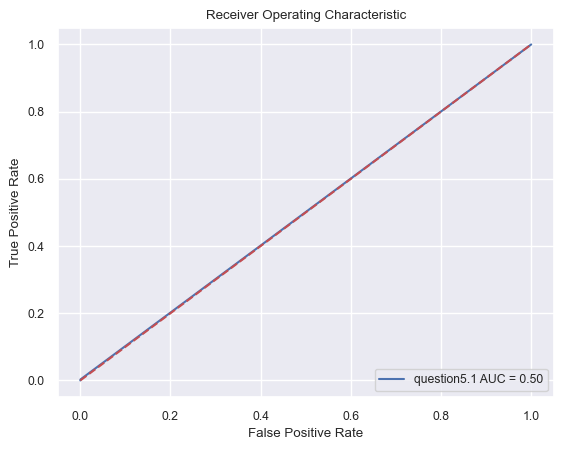

<Figure size 640x480 with 0 Axes>

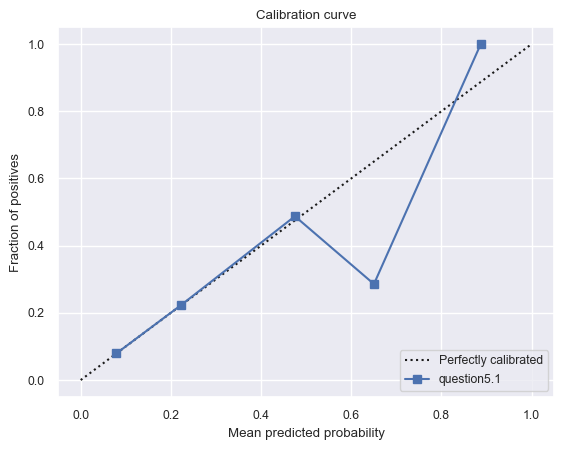

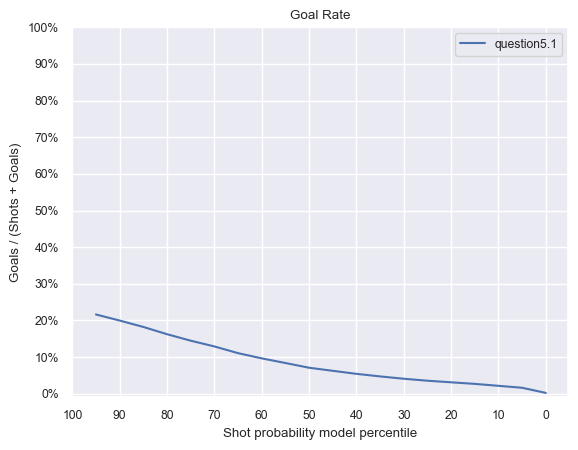

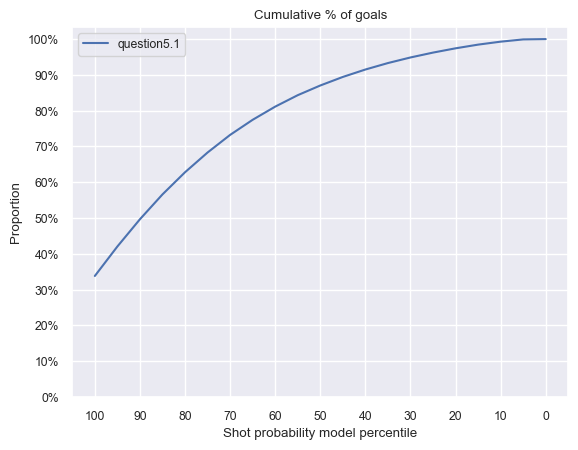

In [202]:
name_experiment = "question5.1"
model_dir = "XGB"

save_metrics_and_models_on_comet(model,y_val,y_val_pred,y_val_prob,model_names=name_experiment,model_dir=model_dir,name_experiment=name_experiment,register_model = False)

## question 5.2

In [8]:
list_features = ['empty_net', 'periodTime','period', 'x_coord', 'y_coord','distance','angle','shot_type',\
    'last_event_type', 'last_x_coord', 'last_y_coord','distance_from_last', 'seconds_since_last', \
        'rebound', 'angle_change','speed']

# preprocess
X, Y ,df_train_preprocessed,_ =  preprocess(df_train,features = list_features, standarize=True)

# train/test split
X_train, X_val, y_train, y_val = train_test_split(X,Y,random_state = 42, shuffle=True,stratify=Y)



In [45]:
# define and train model
model = XGBClassifier()
 
# fit_model
model.fit(X_train,y_train)
y_val_pred,y_val_prob = predict_model(model,X_val)

df_metrics_results = compute_metrics(y_val,[y_val_pred],model_names=['XGB'])
df_metrics_results

,model_name,Accuracy,Recall,Precision,f_score
0,XGB,0.911135,0.532808,0.866628,0.538652


In [46]:
df_metrics_results

,model_name,Accuracy,Recall,Precision,f_score
0,XGB,0.911135,0.532808,0.866628,0.538652


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/princesslove/itf-6758-team-4/3c0776277b6940149c8489460933a59d

COMET WARNING: Converting metric value ''question5.2_without_grid_search'' into a string using str(), resulting string might be invalid
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/princesslove/itf-6758-team-4/3c0776277b6940149c8489460933a59d
COMET INFO:   Metrics:
COMET INFO:     AUC        : 0.5243433271424781
COMET INFO:     Accuracy   : 0.9107740546728216
COMET INFO:     Precision  : 0.955182370440739
COMET INFO:     Recall     : 0.5243433271424781
COMET INFO:     f_score    : 0.52296606500

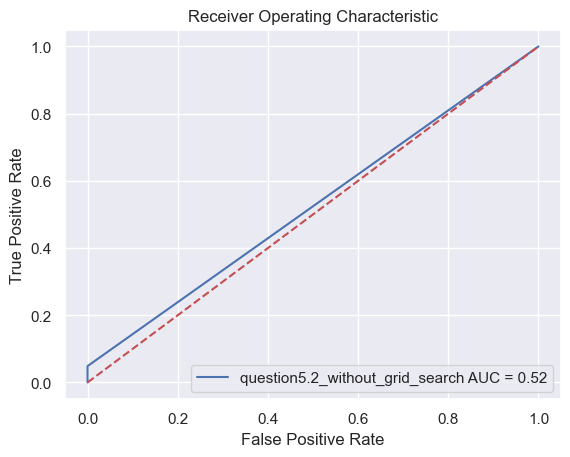

<Figure size 640x480 with 0 Axes>

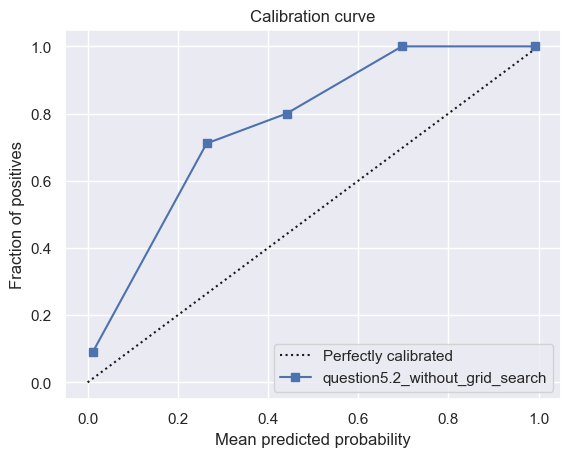

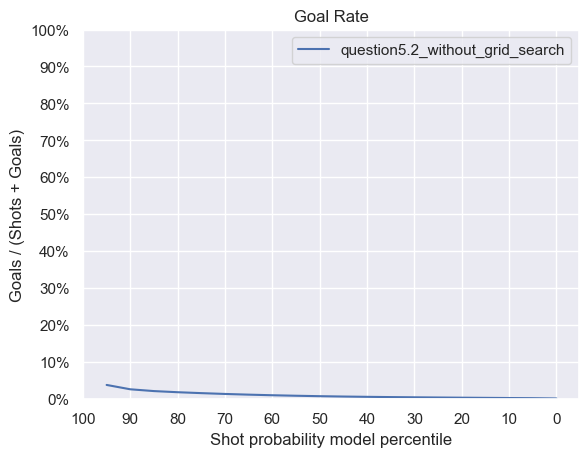

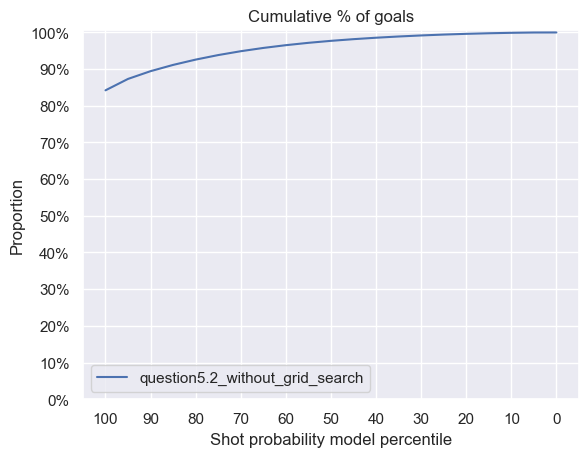

In [11]:
name_experiment = "question5.2_without_grid_search"
model_dir = "XGB"

save_metrics_and_models_on_comet(model,y_val,y_val_pred,y_val_prob,model_names=name_experiment,model_dir=model_dir,name_experiment=name_experiment,register_model = False )

## question 5.2 Performing Cross Validation Grid Search with all features

In [38]:
#setting grid of selected parameters for iteration

param_grid = {'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6],
              'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.5],
              'scale_pos_weight' : [2,3,4,5,6,7],
              'max_depth': [5,6,7,8,9,10,11,12,13,14],
              'n_estimators': [50,65,80,100,115,130,150],
              'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
              'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
              'max_delta_step' : [1,2,3,4,5,6,7,8,9,10],
              'min_child_weight': [1, 5, 10],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'lambda':[0.4, 0.6,0.8,1],
            'alpha':[0, 0.2,0.4,0.6],
            }
'''

param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
'''

"\n\nparam_grid = {\n        'min_child_weight': [1, 5, 10],\n        'gamma': [0.5, 1, 1.5, 2, 5],\n        'subsample': [0.6, 0.8, 1.0],\n        'colsample_bytree': [0.6, 0.8, 1.0],\n        'max_depth': [3, 4, 5]\n        }\n"

In [47]:
# question 5.2

list_features = ['empty_net', 'periodTime','period', 'x_coord', 'y_coord','distance','angle','shot_type',\
    'last_event_type', 'last_x_coord', 'last_y_coord','distance_from_last', 'seconds_since_last', \
        'rebound', 'angle_change','speed']

# preprocess
X, Y ,df_train_preprocessed,_ =  preprocess(df_train,features = list_features, standarize=True)

# train/test split
X_train, X_val, y_train, y_val = train_test_split(X,Y,random_state = 42, shuffle=True,stratify=Y)

# define and train model
model = XGBClassifier(objective='binary:logistic',
                        predictor='cpu_predictor',
                        tree_method = 'hist')

# performing Random Search
folds = 5
param_comb = 100



skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 42)
#rskf = RepeatedStratifiedKFold(n_splits=folds, n_repeats=3, random_state = 42)

random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=param_comb, scoring='f1_macro', n_jobs=-1, cv=skf, verbose=3, random_state=42 )

# Here we go
start_time = time.time() # timing starts from this point for "start_time" variable
random_search.fit(X_train, y_train)
print(time.time() - start_time) # timing ends here for "start_time" variable

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 3/5] END alpha=0.6, colsample_bytree=0.6, gamma=0.8, lambda=0.4, learning_rate=0.01, max_delta_step=2, max_depth=14, min_child_weight=5, n_estimators=100, reg_alpha=0.2, reg_lambda=0, scale_pos_weight=6, subsample=0.8;, score=0.613 total time=  29.5s
[CV 2/5] END alpha=0.6, colsample_bytree=0.6, gamma=0.8, lambda=0.4, learning_rate=0.01, max_delta_step=2, max_depth=14, min_child_weight=5, n_estimators=100, reg_alpha=0.2, reg_lambda=0, scale_pos_weight=6, subsample=0.8;, score=0.620 total time=  29.6s
[CV 4/5] END alpha=0.6, colsample_bytree=0.6, gamma=0.8, lambda=0.4, learning_rate=0.01, max_delta_step=2, max_depth=14, min_child_weight=5, n_estimators=100, reg_alpha=0.2, reg_lambda=0, scale_pos_weight=6, subsample=0.8;, score=0.618 total time=  30.0s
[CV 1/5] END alpha=0.6, colsample_bytree=0.6, gamma=0.8, lambda=0.4, learning_rate=0.01, max_delta_step=2, max_depth=14, min_child_weight=5, n_estimators=100, reg_alpha=0.2

/Users/salhilamia/opt/anaconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 4/5] END alpha=0.4, colsample_bytree=1.0, gamma=0.2, lambda=0.8, learning_rate=0.3, max_delta_step=5, max_depth=7, min_child_weight=1, n_estimators=130, reg_alpha=0.2, reg_lambda=200, scale_pos_weight=4, subsample=1.0;, score=0.629 total time=  12.0s
[CV 5/5] END alpha=0.4, colsample_bytree=1.0, gamma=0.2, lambda=0.8, learning_rate=0.3, max_delta_step=5, max_depth=7, min_child_weight=1, n_estimators=130, reg_alpha=0.2, reg_lambda=200, scale_pos_weight=4, subsample=1.0;, score=0.624 total time=  12.0s
[CV 5/5] END alpha=0.4, colsample_bytree=0.8, gamma=0, lambda=0.8, learning_rate=0.1, max_delta_step=9, max_depth=12, min_child_weight=1, n_estimators=130, reg_alpha=0.1, reg_lambda=200, scale_pos_weight=6, subsample=0.6;, score=0.608 total time=  26.7s
[CV 1/5] END alpha=0.6, colsample_bytree=1.0, gamma=0.2, lambda=0.4, learning_rate=0.1, max_delta_step=4, max_depth=9, min_child_weight=5, n_estimators=150, reg_alpha=6.4, reg_lambda=0.8, scale_pos_weight=7, subsample=0.8;, score=0.596 

KeyboardInterrupt: 

In [ ]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
results


 All results:
{'mean_fit_time': array([ 9.94290886, 10.16183658, 27.93199272, 12.21624446, 14.50529118,
       13.96561995, 16.27526512, 16.400594  , 18.92944841,  6.22001901,
        9.4117588 ,  6.45375547, 10.35748162,  8.66335936,  9.46343002,
        5.56301808,  7.52872562,  7.79941616,  4.46384358,  4.10737882,
        5.70622478, 17.58618569,  3.5058219 ,  7.31400518,  5.08241496,
        4.26398935,  4.74739461,  7.60831223,  3.35633321,  3.94151182,
        5.49025645,  5.23893199,  4.87828102,  4.98453326,  8.82214861,
        3.74984455,  4.23390107,  7.05670505, 10.06917887,  5.43941245,
        3.74261341,  4.71197081,  6.91290507,  6.57041917,  4.96607742,
        7.19112802,  4.75047054,  5.17076306,  5.51969309, 14.76862097,
        4.7847157 , 13.38976407,  8.30766377,  8.0925508 ,  7.23126936,
        7.89175735,  3.79736543,  7.12805586,  3.26488934,  4.80900035,
        3.97032056,  5.67175622,  6.26445403,  5.8450633 ,  4.80656877,
        4.57931385,  3.97438884

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_reg_lambda,param_reg_alpha,param_n_estimators,param_min_child_weight,param_max_depth,...,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,9.942909,0.858304,0.633619,0.077328,1.0,0.2,0.2,50,1,8,...,0.2,"{'subsample': 1.0, 'reg_lambda': 0.2, 'reg_alp...",0.523288,0.525596,0.522226,0.529055,0.523746,0.524782,0.002398,3
1,10.161837,0.079281,0.759668,0.026327,0.8,0.1,25.6,50,1,12,...,0,"{'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alp...",0.521476,0.524774,0.521062,0.527234,0.522937,0.523497,0.002277,48
2,27.931993,3.577575,2.349197,1.174592,1.0,0.4,0.8,150,10,9,...,0.2,"{'subsample': 1.0, 'reg_lambda': 0.4, 'reg_alp...",0.520026,0.522509,0.519403,0.525185,0.521698,0.521764,0.002042,52
3,12.216244,1.353664,0.518008,0.077958,1.0,3.2,0.2,115,5,12,...,0.2,"{'subsample': 1.0, 'reg_lambda': 3.2, 'reg_alp...",0.490341,0.488137,0.489240,0.490341,0.491009,0.489814,0.001012,61
4,14.505291,1.524684,0.616953,0.102971,1.0,3.2,0,130,5,12,...,0,"{'subsample': 1.0, 'reg_lambda': 3.2, 'reg_alp...",0.507849,0.484592,0.482141,0.481023,0.479460,0.487013,0.010551,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,5.852412,0.125648,0.376647,0.011698,1.0,200,51.2,115,10,7,...,0.2,"{'subsample': 1.0, 'reg_lambda': 200, 'reg_alp...",0.476753,0.477429,0.476301,0.476753,0.477435,0.476934,0.000439,69
96,9.360178,0.626020,0.621094,0.115586,0.8,0.4,3.2,130,5,5,...,0.6,"{'subsample': 0.8, 'reg_lambda': 0.4, 'reg_alp...",0.521476,0.524774,0.521062,0.527439,0.522937,0.523538,0.002345,4
97,2.859796,0.147580,0.249345,0.088734,1.0,102.4,0.2,50,1,11,...,0.6,"{'subsample': 1.0, 'reg_lambda': 102.4, 'reg_a...",0.475397,0.475397,0.475397,0.475397,0.475403,0.475398,0.000002,71
98,4.551974,0.059002,0.245874,0.013361,0.6,12.8,1.6,100,10,7,...,0.4,"{'subsample': 0.6, 'reg_lambda': 12.8, 'reg_al...",0.521476,0.524774,0.521062,0.527439,0.522937,0.523538,0.002345,4


In [140]:
random_search.best_params_

{'subsample': 0.8,
 'reg_lambda': 0.4,
 'reg_alpha': 0.4,
 'n_estimators': 130,
 'min_child_weight': 1,
 'max_depth': 11,
 'max_delta_step': 8,
 'learning_rate': 0.300000012,
 'lambda': 0.4,
 'gamma': 0.2,
 'colsample_bytree': 1.0,
 'alpha': 0.6}

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/princesslove/itf-6758-team-4/6af6d5002ac649fdaba0cd53fc66b305
COMET INFO:   Metrics:
COMET INFO:     AUC        : 0.5256150173078846
COMET INFO:     Accuracy   : 0.9109233659744429
COMET INFO:     Precision  : 0.9451651375304568
COMET INFO:     Recall     : 0.5256150173078846
COMET INFO:     f_score    : 0.5253582817481836
COMET INFO:     model_name : question5.2_with_grid_search
COMET INFO:   Others:
COMET INFO:     Name : question5.2_with_grid_search
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     confusion-matrix             : 1
COMET INFO:     environment details          : 1
COMET INFO:     figures        

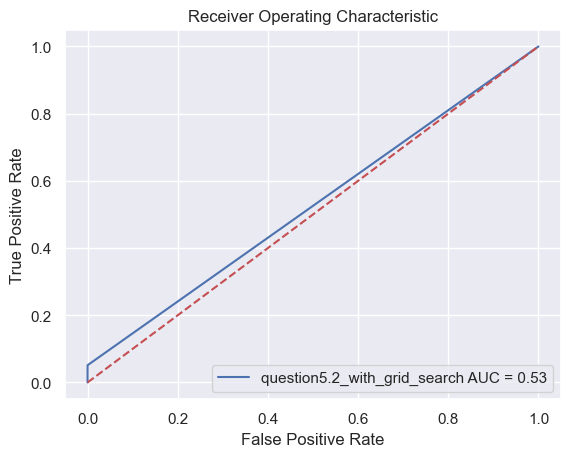

<Figure size 640x480 with 0 Axes>

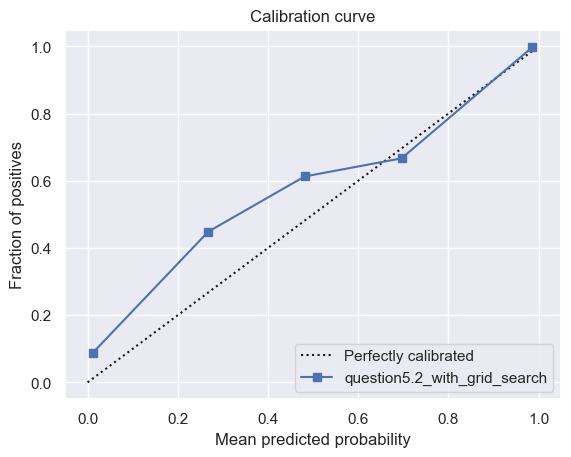

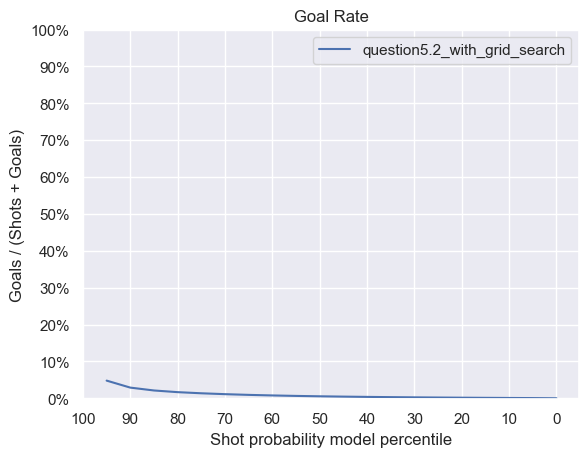

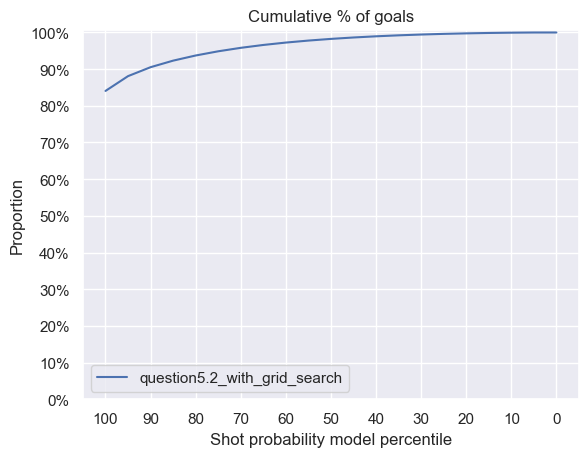

In [21]:
model.set_params(**random_search.best_params_)
# fit model 
model.fit(X_train,y_train)
y_val_pred,y_val_prob = predict_model(model,X_val)

name_experiment = "question5.2_with_grid_search"
model_dir = "XGB"

save_metrics_and_models_on_comet(model,y_val,y_val_pred,y_val_prob,model_names=name_experiment,model_dir=model_dir,name_experiment=name_experiment,register_model = True)

## Question 5.3 (features selection)

In [4]:
# list of features (here all of them)
list_features = ['empty_net', 'periodTime','period', 'x_coord', 'y_coord','distance','angle','shot_type',\
    'last_event_type', 'last_x_coord', 'last_y_coord','distance_from_last', 'seconds_since_last', \
        'rebound', 'angle_change','speed']

# preprocess
X, Y ,df_train_preprocessed,df_train_flag =  preprocess(df_train,features = list_features, standarize=True)

# train/test split
X_train, X_val, y_train, y_val = train_test_split(X,Y,random_state = 42, shuffle=True,stratify=Y)

# concatenate the features and the target in one dataaframe
df_train_total = pd.concat([df_train_preprocessed, pd.DataFrame(Y,columns=['result_event'])], axis=1)

# defining model which will be used for feature selction if necessary
experiment_name = 'question5.2_with_grid_search'

model_xgb_wit_grid_search = XGBClassifier()
model_xgb_wit_grid_search.load_model(f"../models_config/XGB/{experiment_name}.json")

### Explore imbalancement and categorical features balanement

<AxesSubplot: ylabel='count'>

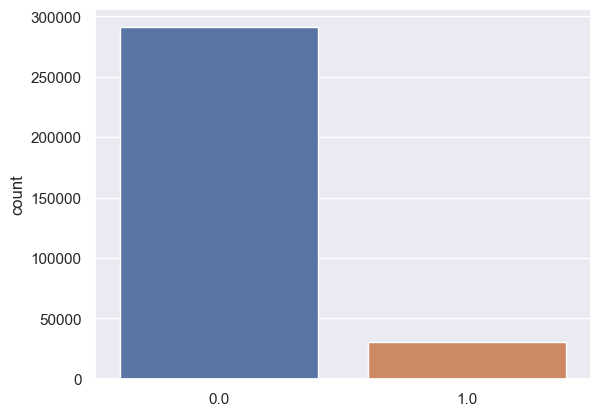

In [9]:
# Count of each labels
sns.countplot(x=Y)

We can see that the data is really imbalanced, for now we solve that by stratifying the train/validation split and by also computing stratified cross validation. Also we set the argument scale_pos_weight of the XGboost model  to  "np.sum(y_train)/len(y_train)".

The imbalancement problem should be handle for the more advanced model of question 6.

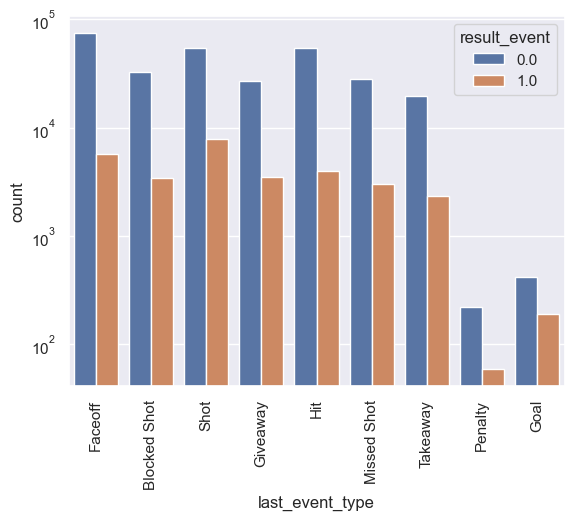

In [11]:
# looking at the last_event_type depending on the target
lest_event_count = sns.countplot(x='last_event_type', hue='result_event', data=df_train_flag,log=True)
loc, labels = plt.xticks()
_ = lest_event_count.set_xticklabels(labels, rotation=90)

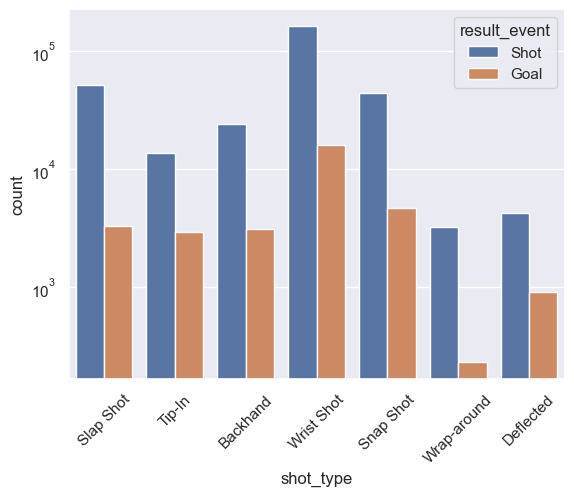

In [7]:
# looking at the shot_type depending on the target
shot_type_count = sns.countplot(x='shot_type', hue='result_event', data=df_train,log=True)
loc, labels = plt.xticks()
_ = shot_type_count.set_xticklabels(labels, rotation=45)

### Exploring XGboost feature importance with SHAP

In [5]:
import xgboost
import shap

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model_xgb_wit_grid_search)
shap_values = explainer(X_val)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [ ]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values, plot_type='violin')

In [ ]:
shap.plots.bar(shap_values)

### Exploring Features correlation through a heatmap

We first check the correlation between all features to check for the redundancies between all the features. Thus we can suppress some features.

<AxesSubplot: >

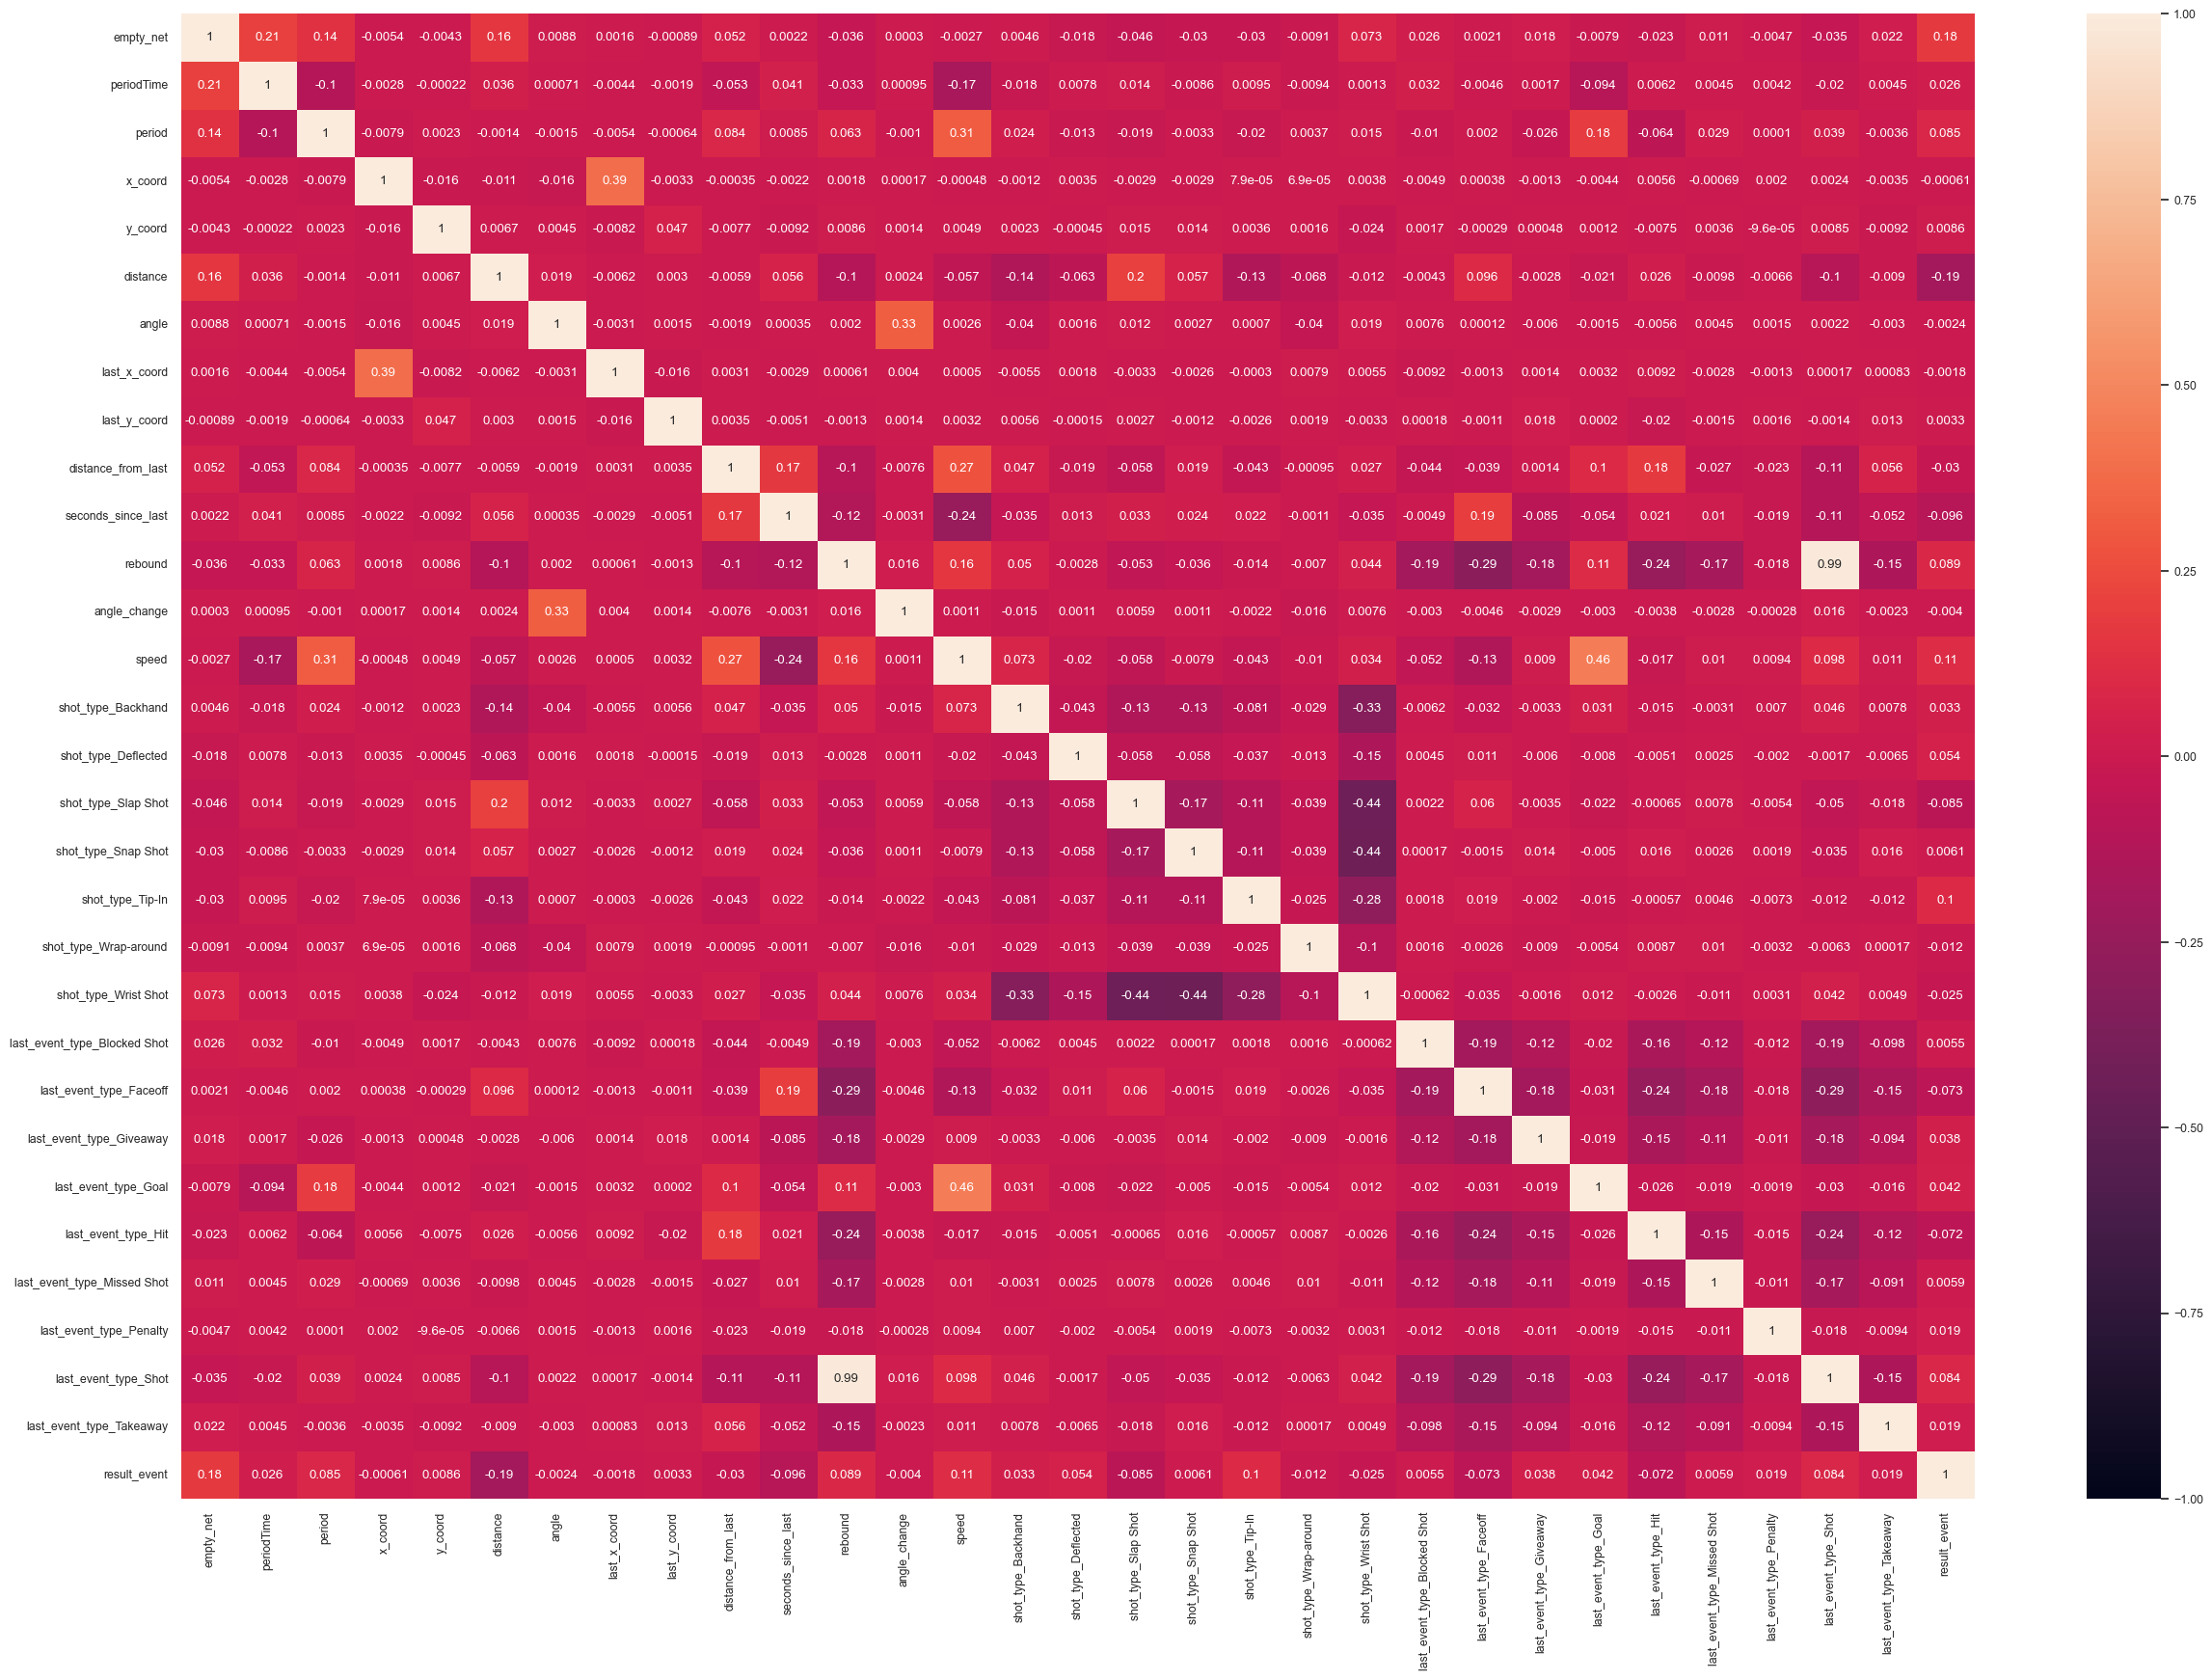

In [48]:
# Heatmap for feature variance
sns.set(font_scale=0.8)
plt.figure(figsize=(30,20))
sns.heatmap(df_train_total.corr(), vmax=1,vmin=-1, annot=True)

we can see that the rebound is highly correlated to the last event type. Which is logical, as the rebound is defined with the last event type.

We can ***suppress the last_event_type_Shot*** as it is less correlated with the target.

Also we can see that the variable that is the most correlated to the result_event is the 'empty_net'. Which seems logical as there are more chance that the shot is goal when the net is empty. For the other parameters the correlation is really small. Especially, we can see that x and y coordinates are not correlated to thee target when intuitively we would think there are. It's because the values are too precised and binning should be applied.

For now we don't perform this kind of preprocessing as the XGboost already handles it but for the next steps we should definitely take this into account.

### Features Selection

In [234]:
# list of features (here all of them)
list_features = ['empty_net', 'periodTime','period', 'x_coord', 'y_coord','distance','angle','shot_type',\
    'last_event_type', 'last_x_coord', 'last_y_coord','distance_from_last', 'seconds_since_last', \
        'rebound', 'angle_change','speed']
# preprocess
X, Y ,df_train_preprocessed,df_train_flag =  preprocess(df_train,features = list_features, standarize=True, drop_fts = ['last_event_type_Shot'])

# train/test split
X_train, X_val, y_train, y_val = train_test_split(X,Y,random_state = 42, shuffle=True, stratify=Y)

# concatenate the features and the target in one dataaframe
df_train_total = pd.concat([df_train_preprocessed, pd.DataFrame(Y,columns=['result_event'])], axis=1)

In [235]:
# consider all features except last_event_type_Shot
feature_names = np.array(df_train_preprocessed.columns.to_list())

#### Based on threshold

In [237]:
from sklearn.feature_selection import VarianceThreshold

# p (1-p) - Only for Boolean features
selector = VarianceThreshold(threshold=0.95)
features = selector.fit_transform(X)

print('Selected Support : ', selector.get_support())

variance_selected_fts = feature_names[selector.get_support()]
print('Selected Features: ', variance_selected_fts)

print('Selected Features shape: ', features.shape)

Selected Support :  [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True]
Selected Features:  ['empty_net' 'periodTime' 'period' 'x_coord' 'y_coord' 'distance' 'angle'
 'last_x_coord' 'last_y_coord' 'distance_from_last' 'seconds_since_last'
 'rebound' 'angle_change' 'speed' 'shot_type_Backhand'
 'shot_type_Deflected' 'shot_type_Slap Shot' 'shot_type_Snap Shot'
 'shot_type_Tip-In' 'shot_type_Wrap-around' 'shot_type_Wrist Shot'
 'last_event_type_Blocked Shot' 'last_event_type_Faceoff'
 'last_event_type_Giveaway' 'last_event_type_Goal' 'last_event_type_Hit'
 'last_event_type_Missed Shot' 'last_event_type_Penalty'
 'last_event_type_Takeaway']
Selected Features shape:  (321475, 29)


We can see that there are not really features with low variance. On this creataria we will keep all the features

#### SelectKBest (avec f score)

In [240]:
from sklearn.feature_selection import SelectKBest,f_classif,chi2
from sklearn.pipeline import Pipeline

In [241]:
def compute_metrics(y_true,y_preds):
    acc = metrics.accuracy_score(y_true,y_preds)
    recall = metrics.recall_score(y_true,y_preds,average='macro')
    precision = metrics.precision_score(y_true,y_preds,average='macro')
    f_score = metrics.f1_score(y_true,y_preds,average='macro')
    return acc,recall, precision,f_score

In [220]:
# Feature Selection
results = {}
for i in range(1, len(feature_names)+1):
    # define pipeline
    xgb_pipeline_select_k_best = Pipeline([('f_classif', SelectKBest(f_classif, k=i)),
                ('xgb', XGBClassifier())
                ])
    
    # fit_model
    xgb_pipeline_select_k_best.fit(X_train[:100000],y_train[:100000])
    y_val_pred,y_val_prob = predict_model(xgb_pipeline_select_k_best,X_val)
    acc,recall, precision,f_score = compute_metrics(y_val, y_val_pred)
    
    results[i] = [acc,recall, precision,f_score]



In [221]:
selet_k_best_results = pd.DataFrame.from_dict(results,orient='index',columns=['acc','recall', 'precision','f_score'])

In [222]:
selet_k_best_results 

,acc,recall,precision,f_score
1,0.910749,0.524211,0.955171,0.522719
2,0.910737,0.524323,0.951127,0.522938
3,0.910227,0.526717,0.866567,0.527625
4,0.910388,0.526331,0.883321,0.526859
5,0.910164,0.527040,0.858892,0.528243
6,0.910264,0.528284,0.853706,0.530532
7,0.910164,0.529537,0.837693,0.532854
8,0.909978,0.529613,0.827229,0.533024
9,0.909878,0.528785,0.827470,0.531529
10,0.910251,0.530299,0.836959,0.534228


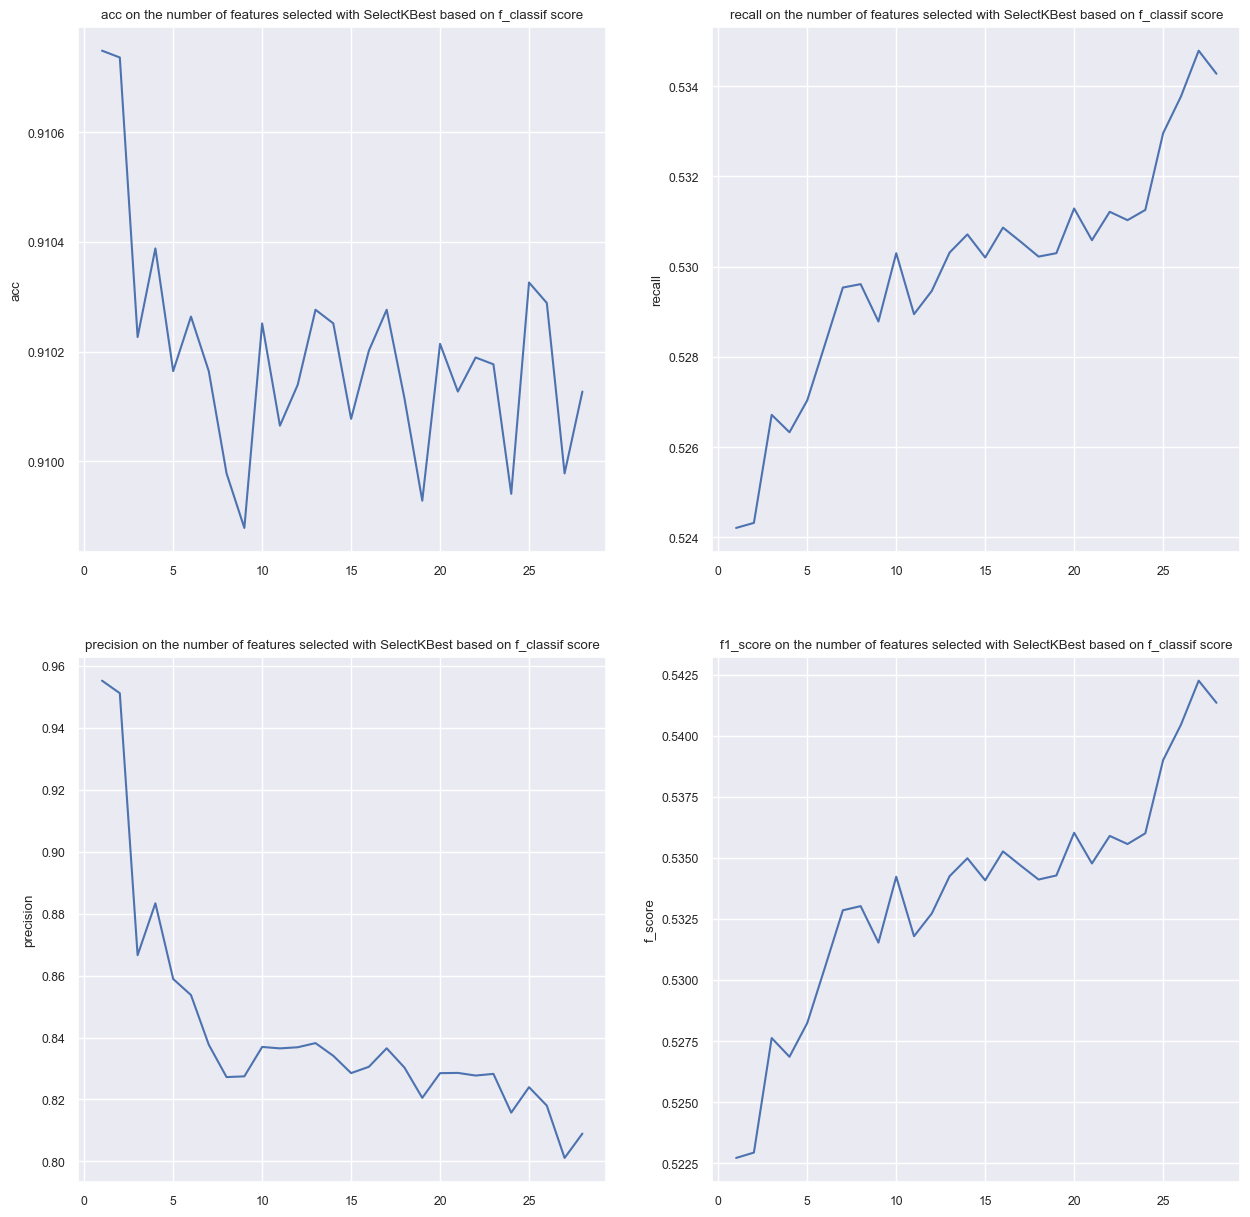

In [223]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

sns.set(font_scale=0.8)

sns.lineplot(data=selet_k_best_results['acc'], ax=axs[0][0])
axs[0][0].set_title('acc on the number of features selected with SelectKBest based on f_classif score')

sns.lineplot(data=selet_k_best_results['precision'], ax=axs[1][0])
axs[1][0].set_title('precision on the number of features selected with SelectKBest based on f_classif score')

sns.lineplot(data=selet_k_best_results['recall'], ax=axs[0][1])
axs[0][1].set_title('recall on the number of features selected with SelectKBest based on f_classif score')

sns.lineplot(data=selet_k_best_results['f_score'], ax=axs[1][1])
axs[1][1].set_title('f1_score on the number of features selected with SelectKBest based on f_classif score')

#plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [239]:
from sklearn.svm import LinearSVC

from sklearn.feature_selection import SelectFromModel

# Select features based KBEST
xgb_pipeline_select_k_best= Pipeline([
  ('feature_selection', SelectKBest(f_classif, k=27)),
  ('classification', XGBClassifier())
])
xgb_pipeline_select_k_best.fit(X_train,y_train)
y_val_pred,y_val_prob = predict_model(xgb_pipeline_select_k_best,X_val)
acc,recall, precision,f_score = compute_metrics(y_val, y_val_pred)
print(f'acc : {acc} \n recall : {recall} \n precision : {precision} \n f_score : {f_score}')


acc : 0.9108113824982269 
 recall : 0.5326296110289441 
 precision : 0.8499805039526043 
 f_score : 0.5383654862949875


In [226]:
fKBest_selected_fts = feature_names[xgb_pipeline_select_k_best['feature_selection'].get_support()]
print('Selected Features: ', fKBest_selected_fts)

Selected Features:  ['empty_net' 'periodTime' 'period' 'y_coord' 'distance' 'angle'
 'last_y_coord' 'distance_from_last' 'seconds_since_last' 'rebound'
 'angle_change' 'speed' 'shot_type_Backhand' 'shot_type_Deflected'
 'shot_type_Slap Shot' 'shot_type_Snap Shot' 'shot_type_Tip-In'
 'shot_type_Wrap-around' 'shot_type_Wrist Shot'
 'last_event_type_Blocked Shot' 'last_event_type_Faceoff'
 'last_event_type_Giveaway' 'last_event_type_Goal' 'last_event_type_Hit'
 'last_event_type_Missed Shot' 'last_event_type_Penalty'
 'last_event_type_Takeaway']


#### LASSO

In [244]:
from sklearn.svm import LinearSVC

from sklearn.feature_selection import SelectFromModel

# Select features based on Lasso
xgb_model = XGBClassifier()
xgb_lasso = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(C=0.001, penalty="l1", dual=False))),
  ('classification', xgb_model)
])
xgb_lasso.fit(X_train,y_train)
y_val_pred,y_val_prob = predict_model(xgb_pipeline_select_k_best,X_val)
acc,recall, precision,f_score = compute_metrics(y_val, y_val_pred)
print(f'acc : {acc} \n recall : {recall} \n precision : {precision} \n f_score : {f_score}')

print('Selected Support : ', xgb_lasso['feature_selection'].get_support())

lasso_selected_fts =feature_names[xgb_lasso['feature_selection'].get_support()]
print('Selected Features: ', lasso_selected_fts)

features = xgb_lasso['feature_selection'].transform(X)
print('Selected Features shape: ', features.shape)

acc : 0.9108113824982269 
 recall : 0.5326296110289441 
 precision : 0.8499805039526043 
 f_score : 0.5383654862949875
Selected Support :  [ True False  True False  True  True False False False  True  True  True
 False  True False  True False  True  True  True  True False  True  True
  True  True False  True  True]
Selected Features:  ['empty_net' 'period' 'y_coord' 'distance' 'distance_from_last'
 'seconds_since_last' 'rebound' 'speed' 'shot_type_Deflected'
 'shot_type_Snap Shot' 'shot_type_Tip-In' 'shot_type_Wrap-around'
 'shot_type_Wrist Shot' 'last_event_type_Faceoff'
 'last_event_type_Giveaway' 'last_event_type_Goal' 'last_event_type_Hit'
 'last_event_type_Penalty' 'last_event_type_Takeaway']
Selected Features shape:  (321475, 19)


#### Sequential Feed forward (forward et backward)

We saw that for the previous method 12 was a good number to select, thus for the sequential feed forward we will arbitrarly choose 12 as the number of features to select

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector
from time import time


tic_fwd = time()
sfs_forward = SequentialFeatureSelector(
    XGBClassifier(), n_features_to_select=12, direction="forward"
).fit(X_train[:50000],y_train[:50000])
toc_fwd = time()

print("Features selected by forward sequential selection: ", f"{feature_names[sfs_forward.get_support()]}")
print(f"Done in {toc_fwd - tic_fwd:.3f}s")

KeyboardInterrupt: 

In [213]:
tic_bwd = time()
sfs_backward = SequentialFeatureSelector(
    XGBClassifier(), n_features_to_select=12, direction="backward"
).fit(X_train[:50000],y_train[:50000])
toc_bwd = time()

print("Features selected by backward sequential selection: ", f"{feature_names[sfs_backward.get_support()]}")
print(f"Done in {toc_bwd - tic_bwd:.3f}s")

KeyboardInterrupt: 

### Comparing the features selection methods (saving them on comet)

In [245]:
list_kept_fts_per_method = [lasso_selected_fts, fKBest_selected_fts,variance_selected_fts]
list_kept_fts_method_names = ['lasso', 'fKBest','variance']

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/princesslove/itf-6758-team-4/22db70860c834ef28f03516767bd7b53

COMET WARNING: Converting metric value ''question_XGB_lasso'' into a string using str(), resulting string might be invalid
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/princesslove/itf-6758-team-4/22db70860c834ef28f03516767bd7b53
COMET INFO:   Metrics:
COMET INFO:     AUC        : 0.5298347380198368
COMET INFO:     Accuracy   : 0.9108113824982269
COMET INFO:     Precision  : 0.8744526530484221
COMET INFO:     Recall     : 0.5298347380198368
COMET INFO:     f_score    : 0.5332865405457223
COMET 

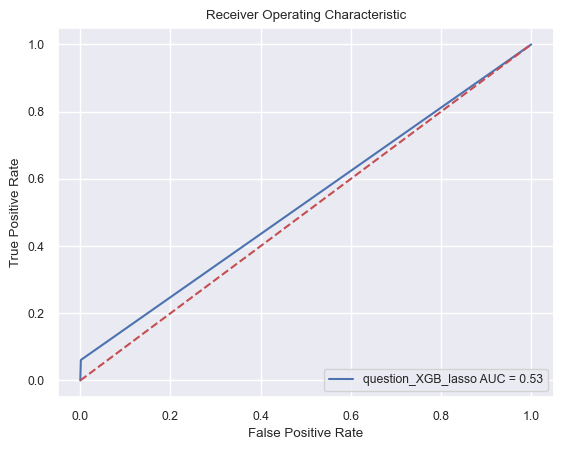

<Figure size 640x480 with 0 Axes>

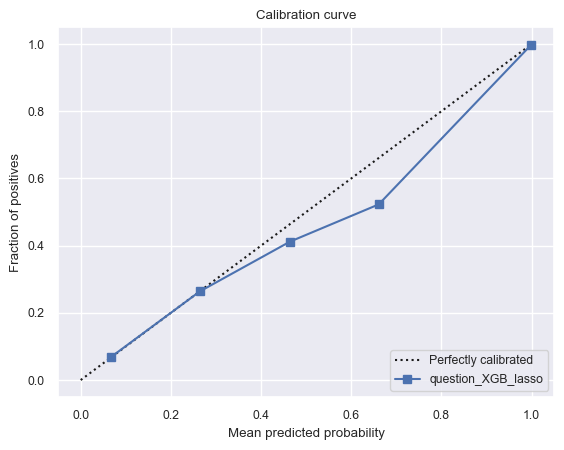

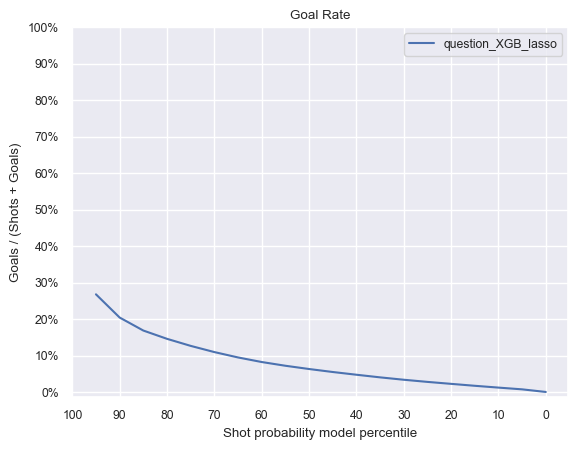

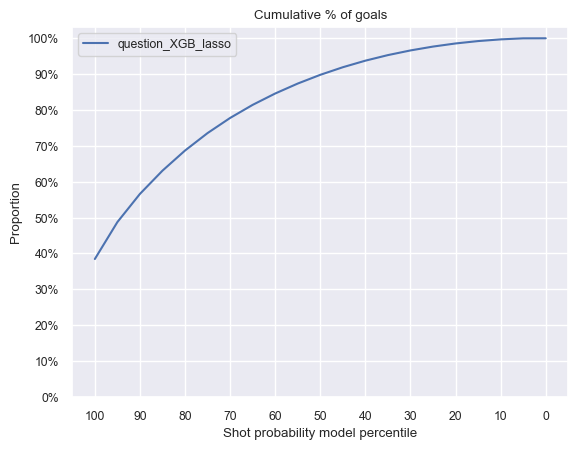

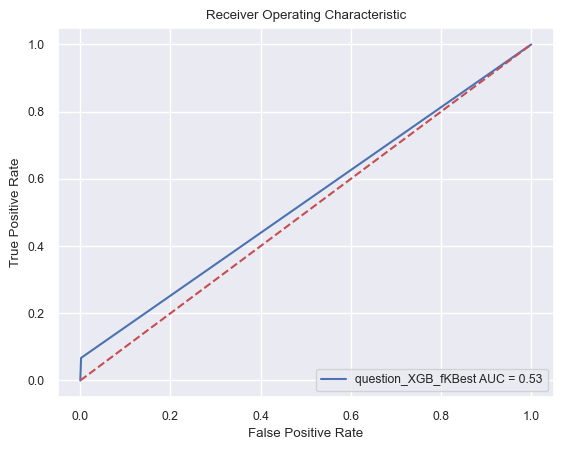

<Figure size 640x480 with 0 Axes>

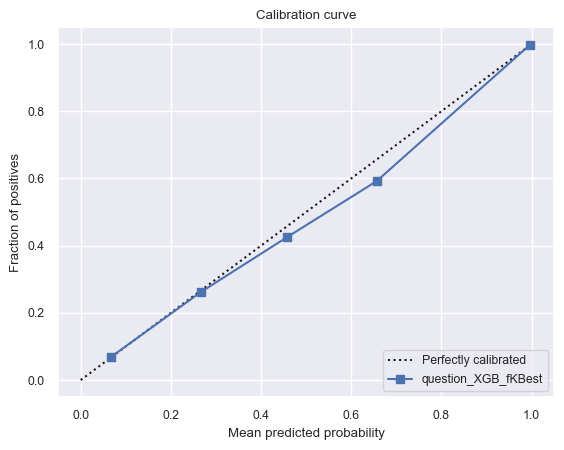

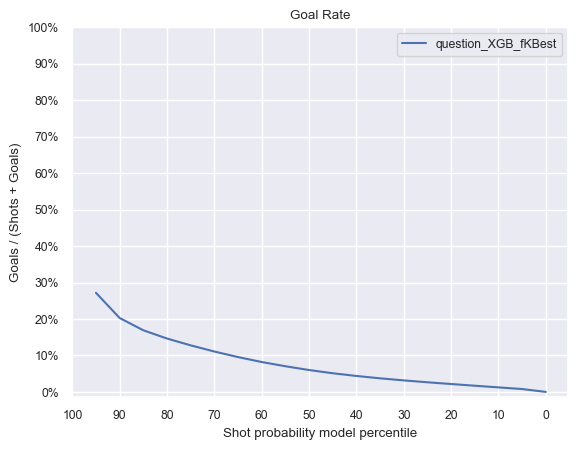

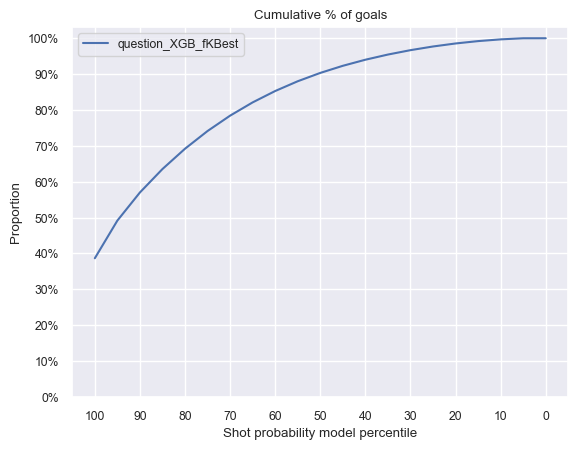

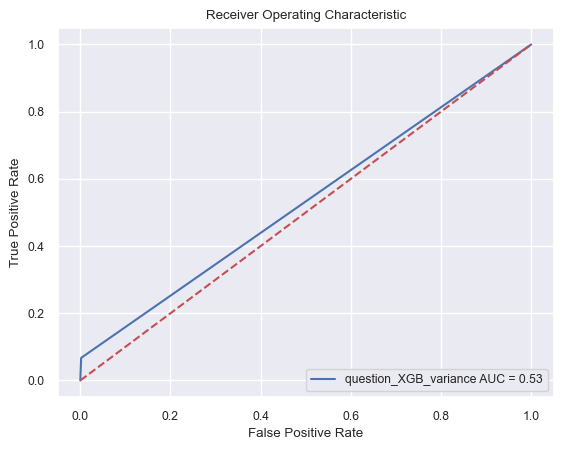

<Figure size 640x480 with 0 Axes>

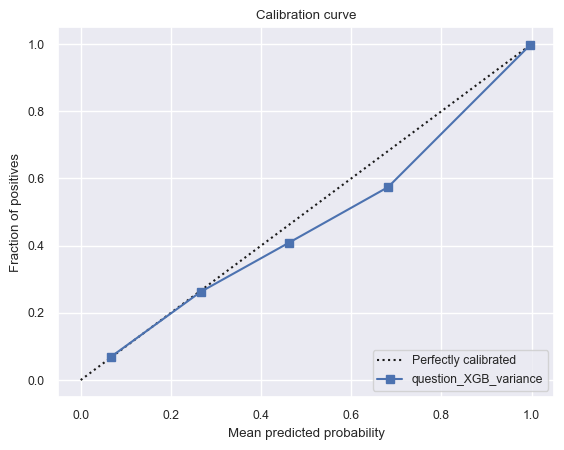

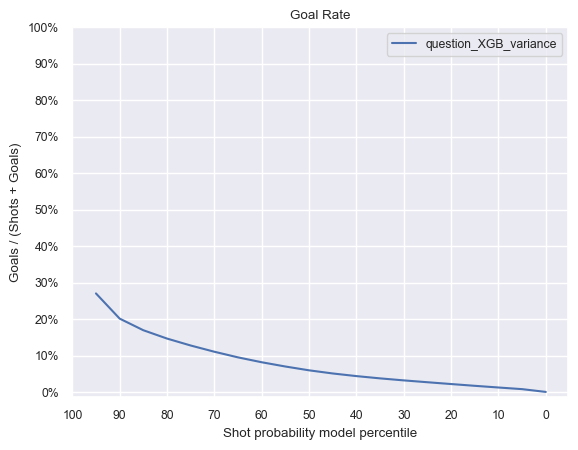

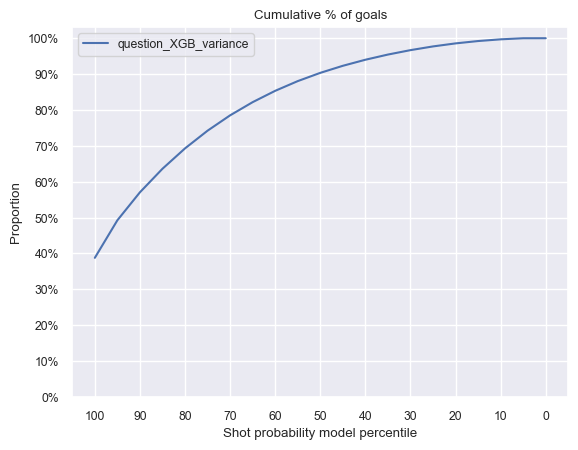

In [246]:
list_features = ['empty_net', 'periodTime','period', 'x_coord', 'y_coord','distance','angle','shot_type',\
    'last_event_type', 'last_x_coord', 'last_y_coord','distance_from_last', 'seconds_since_last', \
        'rebound', 'angle_change','speed']

all_results_per_method = {}
for kept_fts_method, selection_method in zip(list_kept_fts_per_method,list_kept_fts_method_names) : 
    # preprocess
    X, Y ,df_train_preprocessed,_ =  preprocess(df_train,features = list_features, standarize=True, keep_fts = kept_fts_method)

    # train/test split
    X_train, X_val, y_train, y_val = train_test_split(X,Y,random_state = 42, shuffle=True,stratify=Y)

    # define and train model
    model = XGBClassifier()
    
    # fit_model
    model.fit(X_train,y_train)
    y_val_pred,y_val_prob = predict_model(model,X_val)

    name_experiment = f"question_XGB_{selection_method}"
    model_dir = "XGB"

    save_metrics_and_models_on_comet(model,y_val,y_val_pred,y_val_prob,model_names=name_experiment,model_dir=model_dir,name_experiment=name_experiment,register_model = False )
    
    all_results_per_method[selection_method] = [y_val_pred,y_val_prob]

In [268]:
y_val_pred_list = [v[0] for v in all_results_per_method.values()]
y_val_prob_list = [v[1] for v in all_results_per_method.values()]
model_names = all_results_per_method.keys()

compute_metrics(y_val,y_val_pred_list,model_names)

,model_name,Accuracy,Recall,Precision,f_score
0,lasso,0.910811,0.529835,0.874453,0.533287
1,fKBest,0.910923,0.532691,0.855589,0.538465
2,variance,0.910811,0.532630,0.849981,0.538365


### Computing Grid Search on the selected features and saving the models

In [ ]:
final_features_selected = fKBest_selected_fts

In [ ]:
lasso_selected_fts

param_grid = {'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
              'max_depth': [5,6,7,8,9,10,11,12,13,14],
              'n_estimators': [50,65,80,100,115,130,150],
              'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
              'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
              'max_delta_step' : [1,2,3,4,5,6,7,8,9,10],
              #'min_child_weight': [1, 5, 10],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'lambda':[0.4, 0.6,0.8,1],
            'alpha':[0, 0.2,0.4,0.6],
            }

# question 5.2
list_features = ['empty_net', 'periodTime','period', 'x_coord', 'y_coord','distance','angle','shot_type',\
    'last_event_type', 'last_x_coord', 'last_y_coord','distance_from_last', 'seconds_since_last', \
        'rebound', 'angle_change','speed']

# preprocess
X, Y ,df_train_preprocessed,_ =  preprocess(df_train,features = list_features, standarize=True, keep_fts = final_features_selected  )

# train/test split
X_train, X_val, y_train, y_val = train_test_split(X,Y,random_state = 42, shuffle=True,stratify=Y, keep_fts = lasso_selected_fts)

# Select only the features selected

# define and train model
model = XGBClassifier(learning_rate=0.02,\
                        n_estimators=600,\
                        objective='binary:logistic',\
                        #silent=True,
                        scale_pos_weight = np.sum(y_train)/len(y_train),
                        predictor='cpu_predictor',
                        #num_parallel_tree=3,
                        tree_method = 'hist',
                        max_bin=250)

# performing Random Search
folds = 5
param_comb = 100


skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 42)

random_search = GridSearchCV(model, param_distributions=param_grid, scoring='f1_macro', n_jobs=-1, cv=skf, verbose=3, random_state=42 )

# Here we go
start_time = time.time() # timing starts from this point for "start_time" variable
random_search.fit(X_train, y_train)
print(time.time() - start_time) # timing ends here for "start_time" variable

In [ ]:
model.set_params(**random_search.best_params_)
# fit model 
model.fit(X_train,y_train)
y_val_pred,y_val_prob = predict_model(model,X_val)

name_experiment = "question5.3_grid_search_fts_selected"
model_dir = "XGB"

save_metrics_and_models_on_comet(model,y_val,y_val_pred,y_val_prob,model_names=name_experiment,model_dir=model_dir,name_experiment=name_experiment,register_model = True)

## idée d'imporvement

data undeersampling
data oversempling (SMOTE ?)

In [ ]:
QUESRTION 6 : 
Binning
undersampling
PCA (avec la courbe de variance pour connaitre le nombre dee features à séléctionner)

In [192]:
XGBClassifier()

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)